# Homework 3

This is a homework assignment on the material from the 5th week of classes. The deadline for submission is __23:59 on December 17__.

- The homework is done in the same Jupyter Notebook.

- The file should be renamed: __First Name_Last Name__ (no spaces at the beginning or end). Example: __Ivan_Ivanov__.

- Homework should be sent to __OptimizationHomework@yandex.ru__. Subject line: __Skoltech_Task number__ (without spaces at the beginning and end). For this assignment, the subject line is: __Skoltech_3__.

- Place the solution to each problem/item after the condition.

- Do not forget to add necessary explanations and comments.

- All technical artifacts should be removed in the final version that will be sent for checking. By such artifacts we mean any cell outputs that are not commented in any way in the text, as well as any bulk/long technical output (even if it is commented in the text).

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is 100 + 50 (bonus). To get a full score for the hometask you need to get 100.

We wish you success!

### Solving the distributed optimization problem

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the local data size, $s$ is the number of devices, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})} + \lambda w.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 + \lambda$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [356]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
import autograd
import autograd.numpy as anp
import torch
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from scipy.optimize import minimize
import math

import time


In [357]:
dataset = "mushrooms.txt"
#the file must be in the same directory as notebook.

In [358]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [359]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [360]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

In [361]:
def lipschitz_constan(X):
    return np.sum(np.array([np.linalg.norm(x)**2 for x in X ])) * (1 / (4 * X.shape[0])) * 1000 / 999



def function(X, y, lmbd, omega):

    y = torch.from_numpy(y).float()
    X = torch.from_numpy(X).float()
    omega = torch.from_numpy(omega).float().requires_grad_(True)

    return lmbd / 2 * torch.linalg.norm(omega)**2 +  torch.mean(torch.log(1 + torch.exp(-y @ X @ omega )))



def function_jax(X, y, lmbd, omega):

    return lmbd / 2 * jnp.linalg.norm(omega)**2 +  jnp.mean(jnp.log(1 + jnp.exp(-y @ X @ omega )))


def analitical_grad(X, y, lmbd, omega):

    return lmbd * omega + np.mean([X[i] * -y[i]  * (1 / (1 + np.exp(y[i] * omega @ X[i]))) for i in range(X.shape[0])], axis=0)



def function_grad(X, y, lmbd, omega):

    y = torch.from_numpy(y).float()
    X = torch.from_numpy(X).float()
    omega = torch.from_numpy(omega).float().requires_grad_(True)

    f = function(X, y, lmbd, omega)

    f.backward()

    return omega.grad

def grad_f(omega, X, y, lmbd):
    return np.mean((-y / (1 + np.exp(y * np.dot(X, omega))))[:, None] * X, axis=0) + lmbd * omega



In [362]:
L = lipschitz_constan(X_train)
lmbd = L / 1000.


__Problem 0. (10 + 20  points)__ Since we have to deal with a distributed setting, we need to be able to divide the data into parts. The basic variant of this you have most likely already realized in the previous task when dividing data into batches.

In [363]:
def split(X, y, size):

    X_ind = range(X.shape[0])
    X_batches = np.array([])
    y_batches = np.array([])

    i = 0
    while i + size <= len(X_ind):

        X_batches = np.append(X_batches, X[i:i + size])
        y_batches = np.append(y_batches, y[i:i + size])
        i += size

    return X_batches.reshape((X.shape[0] // size, size, X.shape[1])), y_batches.reshape(X.shape[0] // size, size)

But for more interesting results, additional features can be implemented:

__a). (10 points)__ Divide the data non-uniformly/heterogeneously, e.g., give some of the devices predominantly data with labels equal to $1$ and others with $- 1$. You can use this example, or you can figure out your own way how to split the data heterogeneously. In any case, describe your approach and implement it. Ideally, you should be able to vary the degree of heterogeneity from "uniformly" to "absolutely different" splits.

I just devide whole batches on 2 groups. First group receives data with label 1 with probabiliti alpha, another group with probabiliti 1 - alpha

In [364]:
def split_hetero(X, y,  size, alpha):

    X_plus = X[np.where(y == 1)]
    X_minus = X[np.where(y == -1)]

    X_batches = np.array([])
    y_batches = np.array([])
    X_ind = range(X.shape[0])
    i = 0
    j = 0
    while i + size <= len(X_ind) / 2:


        X_batches = np.append(X_batches, X_plus[i:i + int(np.round(size * alpha))])
        y_batches = np.append(y_batches, np.ones(int(np.round(size * alpha))))

        X_batches = np.append(X_batches, X_minus[j: j + int(np.round(size * (1 - alpha)))])
        y_batches = np.append(y_batches, -np.ones(int(np.round(size * (1 - alpha)))))

        i += int(np.round(size * alpha))
        j += int(np.round(size * (1 - alpha)))

        X_batches = np.append(X_batches, X_plus[i:i + int(np.round(size * (1 - alpha)))])
        y_batches = np.append(y_batches, np.ones(int(np.round(size * (1 - alpha)))))

        X_batches = np.append(X_batches, X_minus[j: j + int(np.round(size * alpha))])
        y_batches = np.append(y_batches, -np.ones(int(np.round(size * alpha))))

        j += int(np.round(size * alpha))
        i += int(np.round(size * (1 - alpha)))


    N = X_batches.shape[0] // (size * X.shape[1])

    X_batches = X_batches[:N * size * X.shape[1]]
    y_batches = y_batches[:N * size]

    return X_batches.reshape((N, size, X.shape[1])), y_batches.reshape((N, size))



In [365]:
X_b, y_b = split_hetero(X_train, y_train,  100, 0.8)



Distributed computing can be sufficiently simulated on a single device. Absolutely enough, if you do it in the dumbest way with an additional loop.

__b). (bonus 20 points)__ But you can plug in some specialized libraries. For example, ``ray`` library, but you can also use other approaches. Describe what you are going to do. We advise you to make this point if you understand that you have enough time and resources to organize distributed computing.

In [366]:
#your solution (Code and Markdown)

__Problem 1. (30 + 30 points)__ This part of the assignment is related to __local distributed methods__.

__a). (20 points)__ Simulate the distributed enviroment with $s = 10$ and uniformly distributed data. Implement simple Local GD/FedAvg method (Algorithm 1 of [paper](https://arxiv.org/pdf/1909.04746.pdf), the paper considers SGD, but GD is enough for you), where you can choose the number of local steps $H$ as a parameter. Take a step is equal to $\frac{1}{L}$. What is $L$ here? The corresponding paper can give you an answer.

Vary the number of local steps: $H = 1, 5, 10, 20$. Draw the comparison plots for different $H$: 1) value of convergence criterion versus number of communications, 2) accuracy of predictions versus number of communications. Make a conclusion.

In [406]:
def distributed_SGD(X, y, omega_0, gamma, lmbd, N_users, local_step, proportion=0.5, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = grad_f(omega_0, X, y, lmbd)
    omega_new = omega_0
    criterion = True

    batch_size = X.shape[0] // N_users

    i = 0

    if proportion == 0.5:
          X_batches, y_batches = split(X, y, batch_size)
    else:
          X_batches, y_batches = split_hetero(X, y, batch_size, proportion)


    N_users = X_batches.shape[0]

    local_step_size = np.zeros(N_users)

    for j in range(N_users):
      local_step_size[j] = 1.0/lipschitz_constan(X_batches[j])



    while  i < K and criterion:
        start = time.time()
        user_x = np.zeros((N_users, omega_0.shape[0]))
        user_x[:, ] = omega_new


        for j in range(N_users):

          for s in range(local_step):
            user_x[j] = user_x[j] - local_step_size[j] * grad_f(user_x[j], X_batches[j], y_batches[j], lmbd)

        tmp_omega = omega_new.copy()
        omega_new = user_x.mean(axis=0)
        omega_0 = tmp_omega.copy()


        tmp = np.linalg.norm(grad_f(omega_new, X_batches[j], y_batches[j], lmbd)) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega_new >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega_new, criterions, accuracy, T


In [417]:
# omega_0 = np.ones(X_train.shape[1])/np.sqrt(X_train.shape[1])
omega_0 = np.random.uniform(0, 1, size = (X.shape[1],))

gamma = 1.0
N_users = 10
iters = 1000

loc_steps = np.array([1, 5, 10, 20])
crit = np.array([])

for local_step in loc_steps:
  omega_new, criterions, accuracy, T = distributed_SGD(X_train, y_train, omega_0, gamma, lmbd, N_users, local_step, proportion=0.5, K = iters, eps = 1e-5)
  crit = np.append(crit, criterions)

In [418]:
crit = crit.reshape((4, iters))
crit

array([[0.99880442, 0.99766699, 0.99627468, ..., 0.00997367, 0.00996678,
        0.00995991],
       [0.98987676, 0.6354172 , 0.19036624, ..., 0.00667245, 0.00667248,
        0.0066725 ],
       [0.63819208, 0.11551748, 0.0877388 , ..., 0.00671216, 0.00671216,
        0.00671216],
       [0.11685686, 0.07476831, 0.0592746 , ..., 0.00677457, 0.00677457,
        0.00677457]])

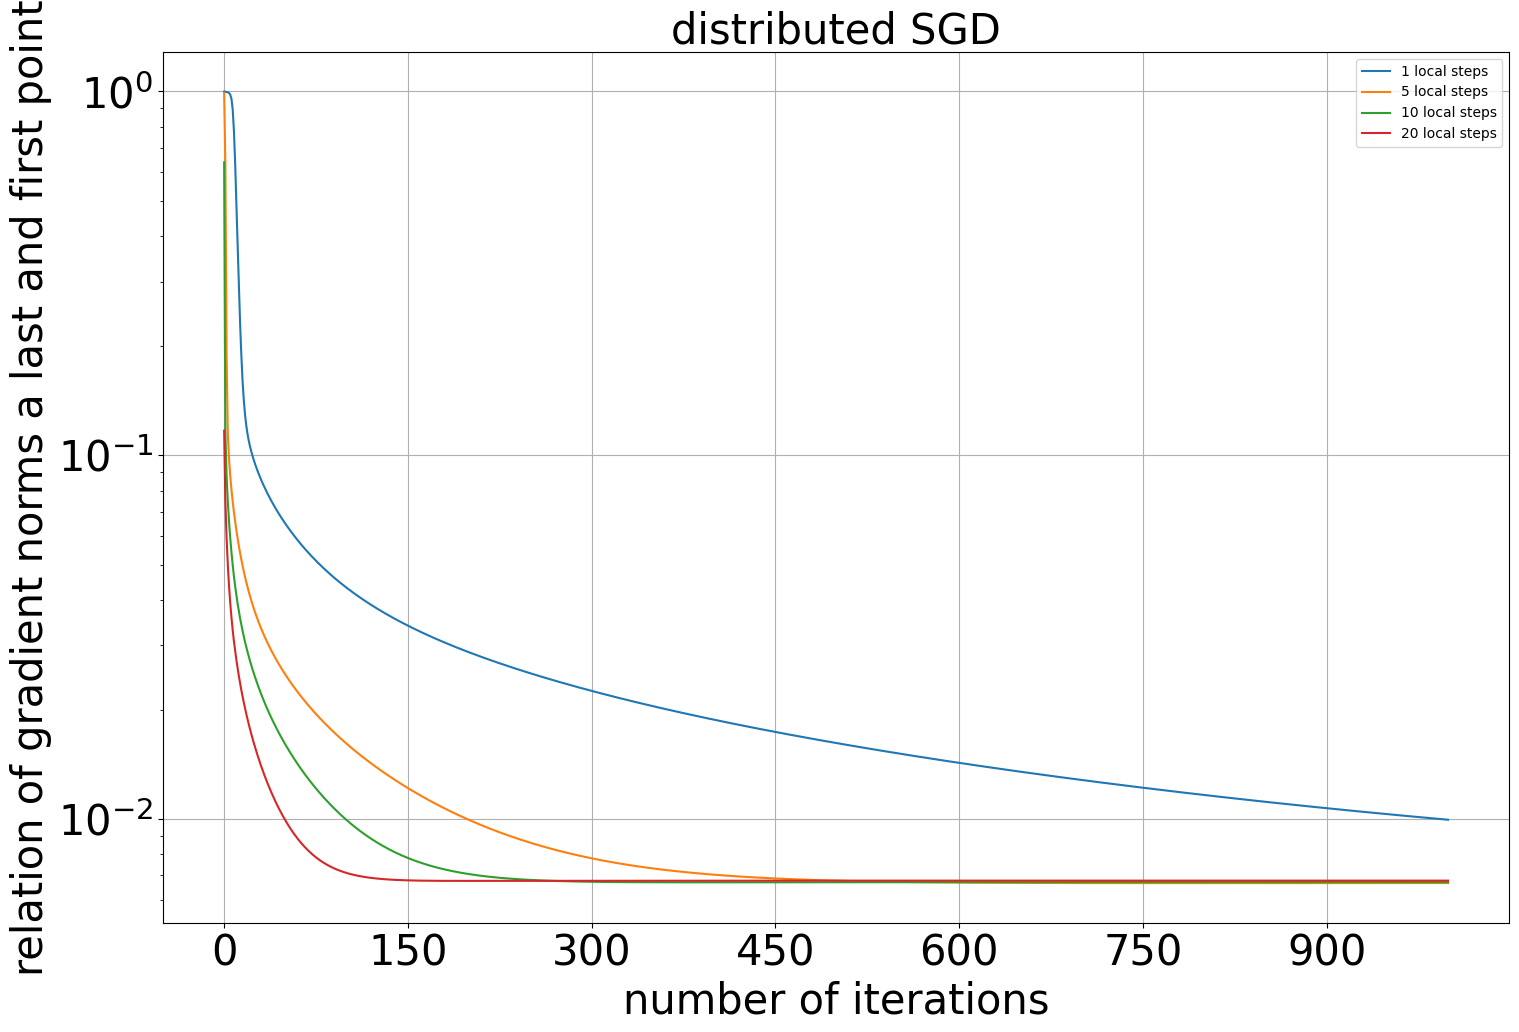

In [419]:
f,ax1 = plt.subplots(1,figsize = (15,10))


for i in range(len(crit)):

  ax1.plot(range(iters), crit[i], label = str(loc_steps[i]) + " local steps")


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('relation of gradient norms a last and first point', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('distributed SGD', fontsize = 30)
plt.yscale('log')
plt.show()



As expected, all tries stucs at the same value, but the mor local steps, the faster convergence

__b). (10 points)__ Here we fix $s = 10$, $H = 10$ and change power of heterogeneity. Take a step is equal to $\frac{1}{L}$ (take into account that for each heterogeneity setting it is better to recompute $L$). Draw the comparison plots for $3-5$ different power of heterogeneity: 1) value of convergence criterion versus number of communications, 2) accuracy of predictions versus number of communications. Make a conclusion.

In [426]:
proportions = np.array([0.5, 0.6, 0.7, 0.8])

crit = np.array([])
accur = np.array([])
iters = 1000

for p in proportions:
  omega, criterions, accuracy, T = distributed_SGD(X_train, y_train, omega_0, gamma, lmbd, N_users=10, local_step=10, proportion=p, K = iters, eps = 1e-5)

  crit = np.append(crit, criterions)

  accur = np.append(accur, accuracy)


In [427]:
crit = crit.reshape((4, iters))



ValueError: ignored

(4004,)

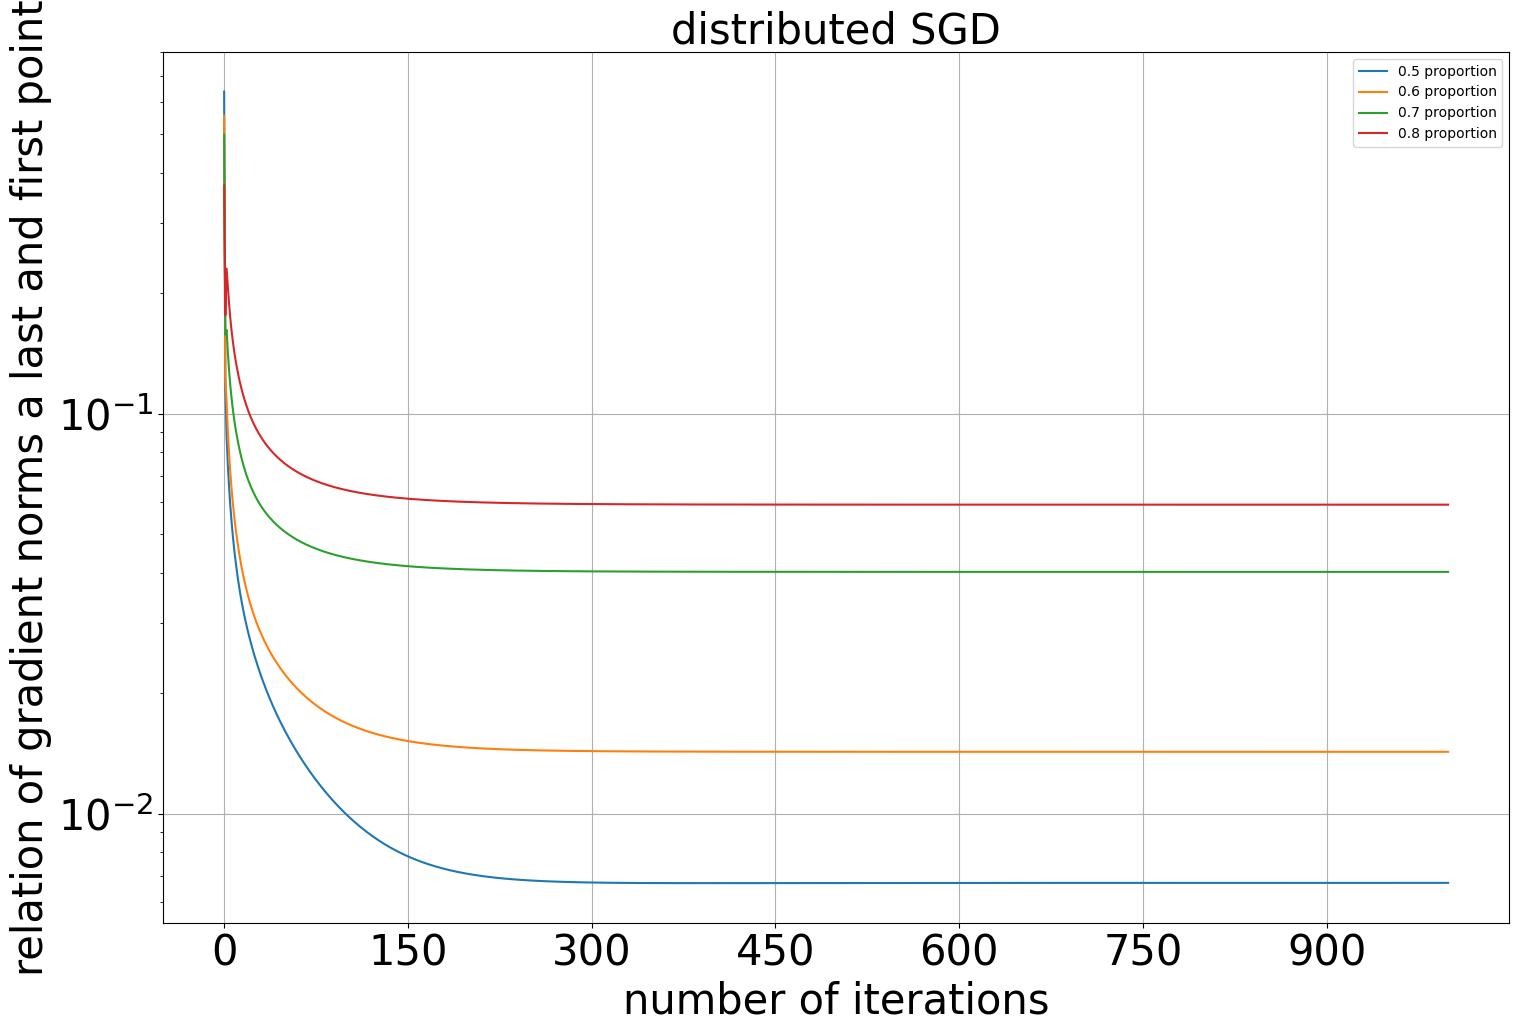

In [425]:
f,ax1 = plt.subplots(1,figsize = (15,10))


for i in range(len(crit)):

  ax1.plot(range(iters), crit[i], label = str(proportions[i]) + " proportion")


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('relation of gradient norms a last and first point', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('distributed SGD', fontsize = 30)
plt.yscale('log')
plt.show()


The more biased proportion, the worth performance

__c). (bonus 30 points)__ We hope that in the previous point you have managed to achieve that with strong data heterogeneity the results of Local GD become to worse and worse. To solve this problem the SCAFFOLD method was proposed. Implement SCAFFOLD (Algorithm 1 of [paper](http://proceedings.mlr.press/v119/karimireddy20a/karimireddy20a.pdf), no need in clients sampling: in line 4 $S = \{1, \ldots, N \}$, no need in stochastic gradients: use full local gradients). Repeat points a)-b) for SCAFFOLD and compare it with Local SGD.

In [ ]:
#your solution (Code and Markdown)

__Problem 2. (60 points)__ This part of the assignment is related to __distributed with compression__ methods.

__а). (10 points)__ Implement the $\text{Rand}k$ and $\text{Top}k$ compression operators, where $k$ is a parameter.

In [474]:
def Randk(x, k):

  d = x.shape[0]
  a = np.arange(d - 1)
  np.random.shuffle(a)
  y = np.zeros(d)

  for tmp in a[:k]:
    y[tmp] = 1

  return d / k * y * x

def Topk(x, k):

  top = np.sort(x)[::-1][:k][-1]

  for i in range(x.shape[0]):
    if x[i] < top:
      x[i] = 0

  return x



In [478]:
N = 10
k = 3
x = np.random.rand(N)
print(x)


[3.32893112e-01 7.42292396e-03 1.16943364e-02 6.84341349e-01
 9.76732722e-01 1.50212115e-01 3.83379275e-01 6.29242182e-01
 6.92614409e-04 7.76216674e-01]


In [479]:
Randk(x, k)

array([1.10964371, 0.        , 0.03898112, 2.28113783, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [480]:
Topk(x, k)

array([0.        , 0.        , 0.        , 0.68434135, 0.97673272,
       0.        , 0.        , 0.        , 0.        , 0.77621667])

__b). (15 points)__ Simulate a distributed  environment with $s=10$ parts and uniformly distributed data. Implement simple distributed gradient descent with compression operators. Compress information only from the devices to the server. Use compression operators $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Use steps are equal to $L^{-1} (\frac{2 \omega}{s} + 1)^{-1}$ (theoretical). Explain what is $L$ and $\omega$ here.

Draw the comparison plots for different operators: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__c). (10 points)__ Try to tune the step for each case from the previous point. Explain how you determine that the step is "the best" (there is no universal recipe here, just your thoughts)

Draw the comparison plots for different operators and tuned steps for them: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__d). (10 points)__ Here we fix $s = 10$, $\text{Rand}10\%$ and change power of heterogeneity. Take a step is equal to $L^{-1} (\frac{2 \omega}{s} + 1)^{-1}$ (take into account that for each heterogeneity setting it is better to recompute $L$). Draw the comparison plots for $3-5$ different power of heterogeneity: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__e). (15 points)__ Now we use $s=10$, uniformly distributed data and $\text{Top}10\%$ as compression operators. Compress the information only from the devices to the server. Use two methods: simple distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). For each method, select the step for the "best" convergence. Draw the comparison plots for two approaches without and with error feedback with "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)